<a href="https://colab.research.google.com/github/MimiSyam/FYP/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os

directory = '/content/drive/MyDrive/VGG19/skinTone_type_all'
class_names = os.listdir(directory)
num_classes = len(class_names)

In [9]:
import cv2
import numpy as np
from keras.applications import VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
# Set the image size for VGG19
imSize = 224

In [11]:
# Lists to store images and labels
train_images = []
train_labels = []

In [ ]:
# Initialize an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [12]:
for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(directory, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        fundIm = cv2.imread(image_path)
        resizeIm = cv2.resize(fundIm, (imSize, imSize))  # Resize image to desired size

        #Apply data augmentation
        #img_batch = np.expand_dims(resizeIm, axis=0)  # Add batch dimension
        #aug_iter = datagen.flow(img_batch, batch_size=1)
        #augmented_images = [next(aug_iter)[0] for _ in range(10)]  # Generate 10 augmented images


        #train_images.extend(augmented_images)
        #train_labels.extend([class_index] * len(augmented_images))

        train_images.append(resizeIm)
        train_labels.append(class_index)



In [13]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [14]:
# Normalize RGB values to [0, 1]
train_images = train_images.astype('float32') / 255.0

In [15]:
# Load the VGG19 model with pre-trained weights (excluding the top layer)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(imSize, imSize, 3))

80134624/80134624 [==============================] - 4s 0us/step


In [16]:
# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(np.unique(train_labels)), activation='softmax')(x)


In [17]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Print a summary of the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [21]:
# Convert labels to one-hot encoded format
label_to_id = {class_names: idx for idx, class_names in enumerate(np.unique(train_labels))}
train_labels_encoded = np.array([label_to_id[class_names] for class_names in train_labels])
train_labels_onehot = to_categorical(train_labels_encoded)

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_onehot, test_size=0.2, random_state=42)

In [23]:
# Train the model
batch_size = 32
epochs = 50


In [24]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/50
28/28 [==============================] - 50s 782ms/step - loss: 5.4963 - accuracy: 0.2705 - val_loss: 0.5737 - val_accuracy: 0.3318
Epoch 2/50
28/28 [==============================] - 13s 453ms/step - loss: 0.5622 - accuracy: 0.3037 - val_loss: 0.5662 - val_accuracy: 0.2318
Epoch 3/50
28/28 [==============================] - 13s 455ms/step - loss: 0.5628 - accuracy: 0.2991 - val_loss: 0.5586 - val_accuracy: 0.3318
Epoch 4/50
28/28 [==============================] - 13s 459ms/step - loss: 0.5600 - accuracy: 0.3128 - val_loss: 0.5615 - val_accuracy: 0.3636
Epoch 5/50
28/28 [==============================] - 13s 464ms/step - loss: 0.5591 - accuracy: 0.2865 - val_loss: 0.5768 - val_accuracy: 0.2318
Epoch 6/50
28/28 [==============================] - 13s 469ms/step - loss: 0.5541 - accuracy: 0.3539 - val_loss: 0.5331 - val_accuracy: 0.4227
Epoch 7/50
28/28 [==============================] - 13s 475ms/step - loss: 0.5226 - accuracy: 0.4406 - val_loss: 0.5232 - val_accuracy: 0.4000

In [25]:
# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9/9 [==============================] - 4s 482ms/step - loss: 0.0752 - accuracy: 0.9854
Test Loss: 0.07517804205417633
Test Accuracy: 0.985401451587677


In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

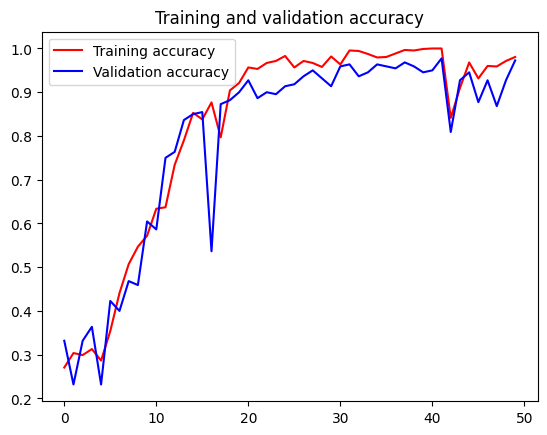

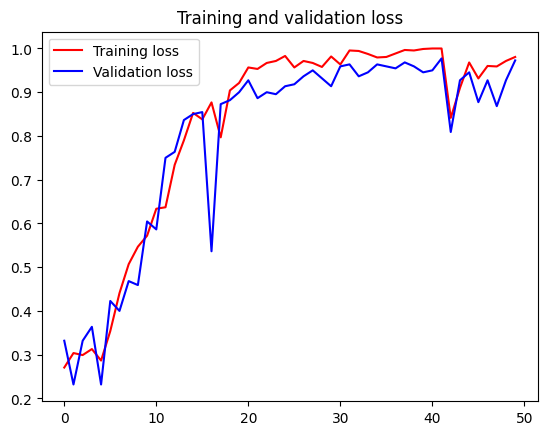

<Figure size 640x480 with 0 Axes>

In [27]:
# Retrieve a list of results on training and test data sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get the number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 0)
plt.figure()

# Plot training and validation lost per epoch
plt.plot(epochs, acc, 'r', label = 'Training loss')
plt.plot(epochs, val_acc, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc = 0)
plt.figure()

9/9 [==============================] - 1s 144ms/step


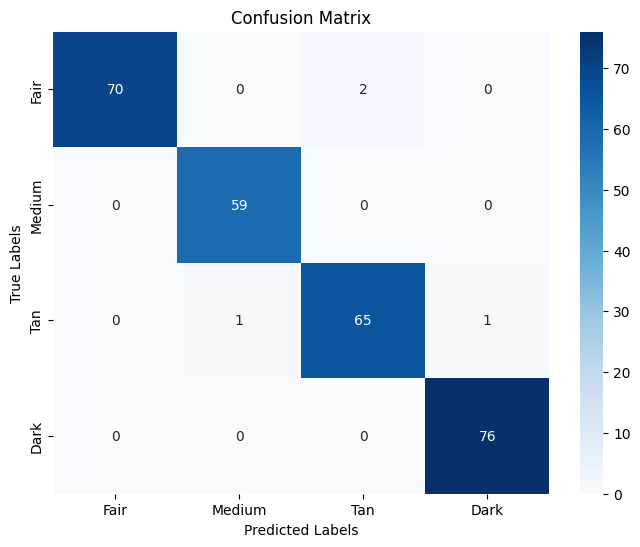

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Perform prediction on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert test_labels to integer format
test_labels_int = np.argmax(y_test, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels_int, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
def calculate_accuracy(confusion_matrix):
    # Extract the values from the confusion matrix
    true_positives = np.diag(confusion_matrix)
    total_predictions = np.sum(confusion_matrix)

    # Calculate the accuracy
    accuracy = np.sum(true_positives) / total_predictions

    return accuracy

# Calculate the accuracy using the confusion matrix
accuracy = calculate_accuracy(cm)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9854014598540146


In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/Model_PSM/6')